<a href="https://colab.research.google.com/github/Kalkidan-Negaro/Bestseller-Predictor/blob/main/Bestseller_Predictor.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Predicting Book Bestsellers Using Logistic Regression

**Dataset:** [Goodreads Books](https://www.kaggle.com/datasets/jealousleopard/goodreadsbooks)  
**Description:** This notebook implements a Logistic Regression model from scratch to predict whether a book will become a bestseller based on features such as average rating, number of ratings, number of reviews, and number of pages.  


## 1. Install and Import Libraries

In this block, we set up the environment by installing the Kaggle API and importing all necessary Python libraries for data analysis, visualization, and modeling.


In [26]:
# Install Kaggle API
!pip install kaggle --quiet

# Import necessary libraries
import os
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from pyspark.sql import SparkSession

print("Libraries imported successfully")

Libraries imported successfully


## 2. Set Up Kaggle API Credentials

In this block, we configure the Kaggle API to enable downloading datasets directly from Kaggle.


In [27]:

# Create the Kaggle configuration directory
os.makedirs(os.path.expanduser("~/.kaggle"), exist_ok=True)

# Define Kaggle API credentials
kaggle_json = """{
  "username": "kalkidannegaro",
  "key": "1543f1e787a6b8002084cd470cecda1c"
}"""

# Save the credentials to the appropriate file
with open(os.path.expanduser("~/.kaggle/kaggle.json"), "w") as f:
    f.write(kaggle_json)

# Set secure file permissions
!chmod 600 ~/.kaggle/kaggle.json

print("Kaggle API configured successfully")

Kaggle API configured successfully


## 3. Initialize Spark Session

In this block, we create a Spark session to enable distributed data processing and to work efficiently with large datasets.


In [28]:
spark = SparkSession.builder.appName("BookBestsellerEDA").getOrCreate()
print("Spark session started")


Spark session started


## 4. Download and Load Dataset

In this block, we download the Goodreads Books dataset from Kaggle, load it into a Pandas DataFrame, and display the first few rows to inspect the data.


In [14]:
# Define dataset path
dataset_path = "/content/books_data/books.csv"

# Load dataset with robust parsing to skip bad lines
books_df = pd.read_csv(dataset_path, encoding='latin1', on_bad_lines='skip')

# Strip whitespace from column names
books_df.columns = books_df.columns.str.strip()

# Display dataset info and first few rows
print("Dataset loaded successfully!")
print("Shape:", books_df.shape)
books_df.head()

Dataset loaded successfully!
Shape: (11123, 12)


,bookID,title,authors,average_rating,isbn,isbn13,language_code,num_pages,ratings_count,text_reviews_count,publication_date,publisher
0,1,Harry Potter and the Half-Blood Prince (Harry ...,J.K. Rowling/Mary GrandPrÃ©,4.57,0439785960,9780439785969,eng,652,2095690,27591,9/16/2006,Scholastic Inc.
1,2,Harry Potter and the Order of the Phoenix (Har...,J.K. Rowling/Mary GrandPrÃ©,4.49,0439358078,9780439358071,eng,870,2153167,29221,9/1/2004,Scholastic Inc.
2,4,Harry Potter and the Chamber of Secrets (Harry...,J.K. Rowling,4.42,0439554896,9780439554893,eng,352,6333,244,11/1/2003,Scholastic
3,5,Harry Potter and the Prisoner of Azkaban (Harr...,J.K. Rowling/Mary GrandPrÃ©,4.56,043965548X,9780439655484,eng,435,2339585,36325,5/1/2004,Scholastic Inc.
4,8,Harry Potter Boxed Set Books 1-5 (Harry Potte...,J.K. Rowling/Mary GrandPrÃ©,4.78,0439682584,9780439682589,eng,2690,41428,164,9/13/2004,Scholastic


## 5. Exploratory Data Analysis (EDA)

In this block, we clean the dataset by removing irrelevant columns and handling missing values. We then explore the numeric features using summary statistics, correlation matrices, and visualizations such as histograms and scatterplots to understand distributions, patterns, and relationships between features that could influence whether a book becomes a bestseller.


Data Types:
 title                  object
authors                object
average_rating        float64
language_code          object
num_pages               int64
ratings_count           int64
text_reviews_count      int64
bestseller              int64
dtype: object

Missing Values:
 title                 0
authors               0
average_rating        0
language_code         0
num_pages             0
ratings_count         0
text_reviews_count    0
bestseller            0
dtype: int64

Summary statistics:
       average_rating     num_pages  ratings_count  text_reviews_count  \
count    11123.000000  11123.000000   1.112300e+04        11123.000000   
mean         3.934075    336.405556   1.794285e+04          542.048099   
std          0.350485    241.152626   1.124992e+05         2576.619589   
min          0.000000      0.000000   0.000000e+00            0.000000   
25%          3.770000    192.000000   1.040000e+02            9.000000   
50%          3.960000    299.000000   7.45000

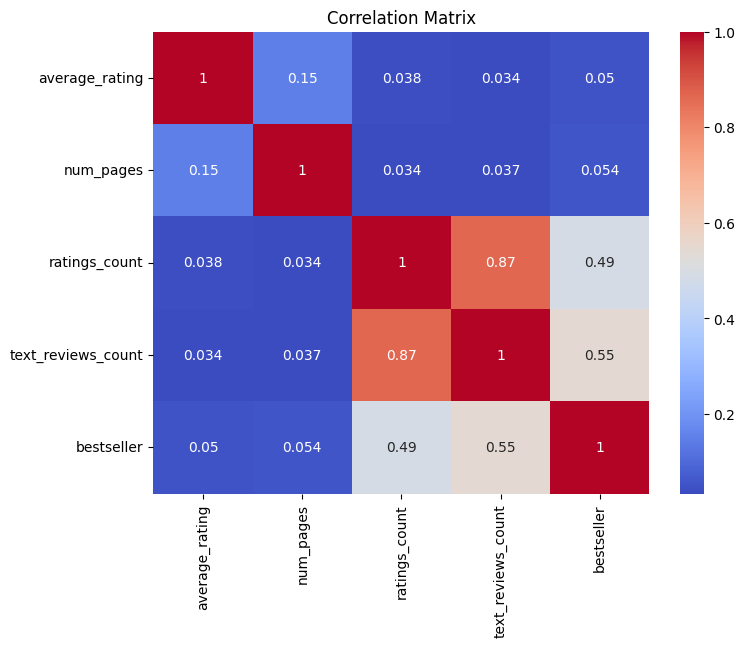

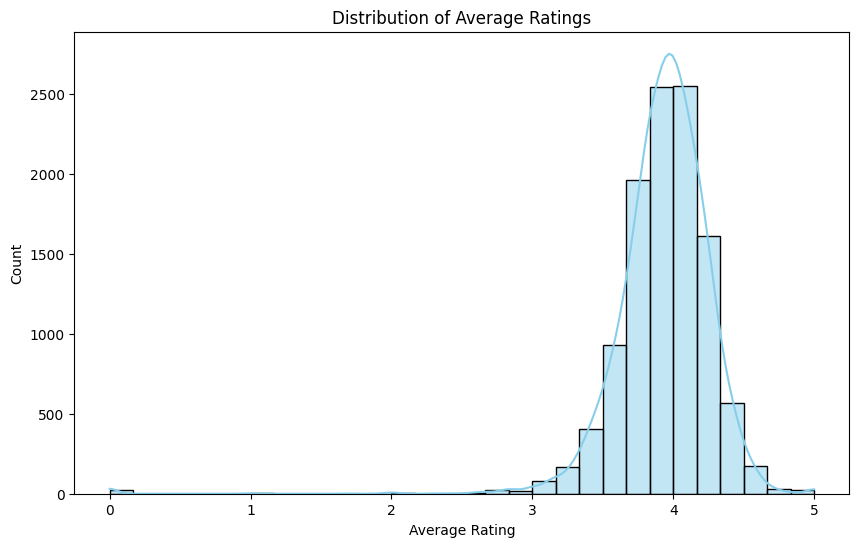

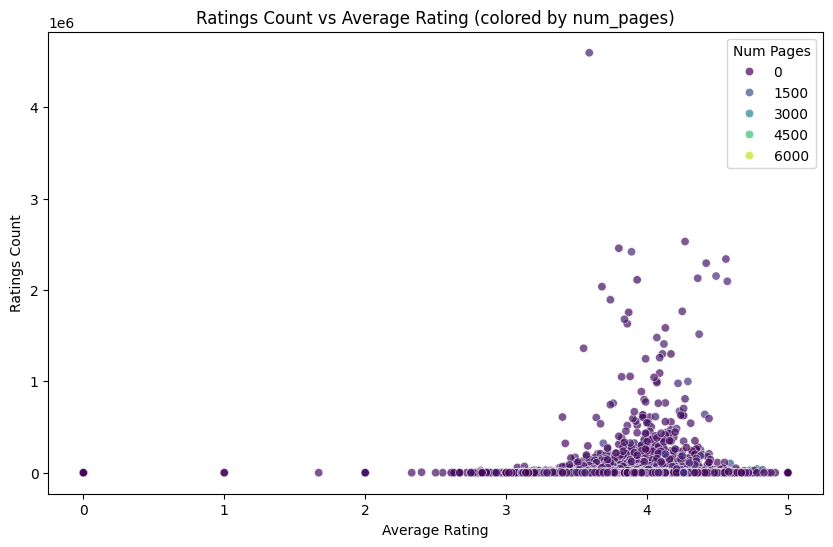

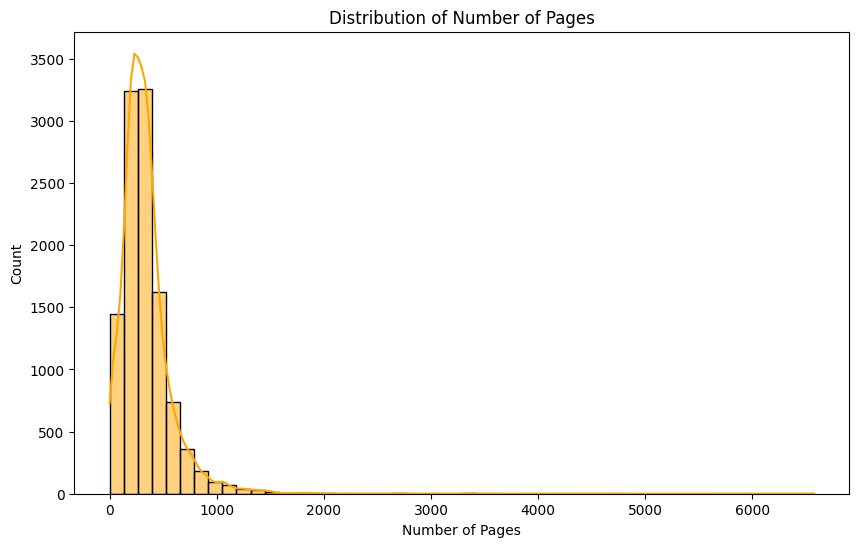

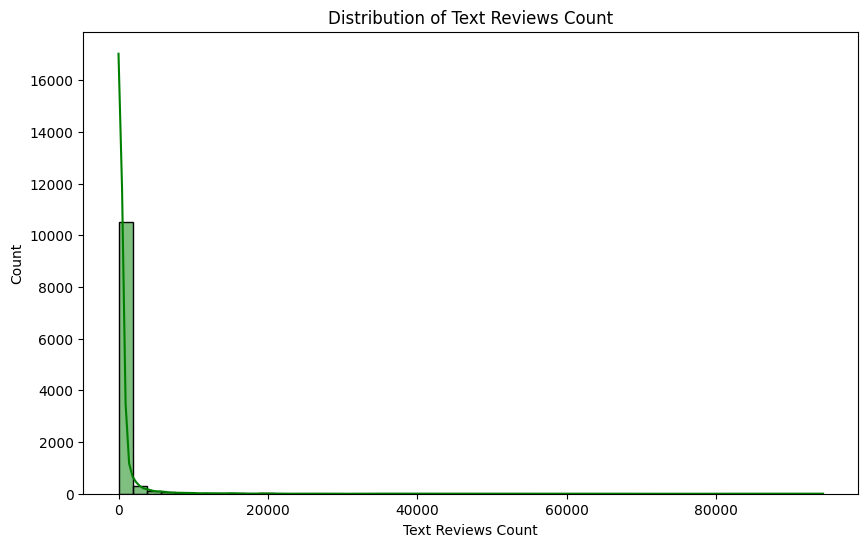

In [21]:
import matplotlib.pyplot as plt
import seaborn as sns

# Strip whitespace from column names
books_df.columns = books_df.columns.str.strip()

# Check missing values and data types
print("Data Types:\n", books_df.dtypes)
print("\nMissing Values:\n", books_df.isnull().sum())

# Drop irrelevant or non-numeric columns
books_df = books_df.drop(columns=["isbn", "isbn13", "bookID", "publication_date", "publisher"], errors='ignore')

# Drop rows with missing critical numeric values
books_df = books_df.dropna(subset=["average_rating", "ratings_count", "text_reviews_count", "num_pages"])

# Summary statistics
print("\nSummary statistics:")
print(books_df.describe())


# Correlation heatmap (numeric only)
numeric_cols = books_df.select_dtypes(include=['float64', 'int64'])
plt.figure(figsize=(8,6))
sns.heatmap(numeric_cols.corr(), annot=True, cmap='coolwarm')
plt.title("Correlation Matrix")
plt.show()

# Distribution of average ratings
plt.figure(figsize=(10,6))
sns.histplot(books_df['average_rating'], bins=30, kde=True, color='skyblue')
plt.title("Distribution of Average Ratings")
plt.xlabel("Average Rating")
plt.ylabel("Count")
plt.show()

# Scatterplot: Ratings Count vs Average Rating
plt.figure(figsize=(10,6))
sns.scatterplot(
    x='average_rating',
    y='ratings_count',
    data=books_df,
    hue='num_pages',
    palette='viridis',
    alpha=0.7
)
plt.title("Ratings Count vs Average Rating (colored by num_pages)")
plt.xlabel("Average Rating")
plt.ylabel("Ratings Count")
plt.legend(title='Num Pages')
plt.show()

# Histogram: Number of Pages
plt.figure(figsize=(10,6))
sns.histplot(books_df['num_pages'], bins=50, kde=True, color='orange')
plt.title("Distribution of Number of Pages")
plt.xlabel("Number of Pages")
plt.ylabel("Count")
plt.show()

# Histogram: Text Reviews Count
plt.figure(figsize=(10,6))
sns.histplot(books_df['text_reviews_count'], bins=50, kde=True, color='green')
plt.title("Distribution of Text Reviews Count")
plt.xlabel("Text Reviews Count")
plt.ylabel("Count")
plt.show()


## 6. Feature Engineering and Data Preparation

In this block, we create additional features such as `reviews_per_rating` and `pages_per_rating` to better capture patterns in the data. We define the target variable `bestseller` based on a threshold for ratings count, select the relevant features, normalize them, and split the dataset into training and testing sets to prepare for model training.


In [22]:
# Add more features
books_df['reviews_per_rating'] = books_df['text_reviews_count'] / (books_df['ratings_count'] + 1)
books_df['pages_per_rating'] = books_df['num_pages'] / (books_df['ratings_count'] + 1)

# Define bestseller target
threshold = 50000
books_df['bestseller'] = np.where(books_df['ratings_count'] > threshold, 1, 0)

# Features
features = ['average_rating', 'ratings_count', 'text_reviews_count', 'num_pages', 'reviews_per_rating', 'pages_per_rating']
X = books_df[features]
y = books_df['bestseller']

# Normalize features
X = (X - X.mean()) / X.std()

# Train-test split
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

print("Training shape:", X_train.shape)
print("Testing shape:", X_test.shape)

Training shape: (8898, 6)
Testing shape: (2225, 6)


## 7. Train Logistic Regression Model

In this block, we implement Logistic Regression from scratch using gradient descent. We include hyperparameter tuning by testing different learning rates and epoch values, and select the model with the best accuracy on the test set.


In [29]:
# Sigmoid activation function
def sigmoid(z):
    return 1 / (1 + np.exp(-z))

# Logistic Regression training function
def train_logistic_regression(X, y, lr=0.01, epochs=1000):
    X = np.c_[np.ones((X.shape[0], 1)), X]  # bias term
    y = y.values.reshape(-1,1)
    weights = np.zeros((X.shape[1],1))

    for i in range(epochs):
        z = np.dot(X, weights)
        predictions = sigmoid(z)
        gradient = np.dot(X.T, (predictions - y)) / len(y)
        weights -= lr * gradient

        if i % 100 == 0:
            loss = -np.mean(y * np.log(predictions + 1e-9) + (1-y) * np.log(1-predictions + 1e-9))
            print(f"Epoch {i}, Loss: {loss:.4f}")
    return weights

# Hyperparameter tuning example
learning_rates = [0.01, 0.05, 0.1]
epochs_list = [500, 1000]

best_accuracy = 0
best_params = {}

for lr in learning_rates:
    for ep in epochs_list:
        print(f"\nTraining with lr={lr}, epochs={ep}")

        # Train model
        weights = train_logistic_regression(X_train, y_train, lr=lr, epochs=ep)

        # Evaluate
        X_test_bias = np.c_[np.ones((X_test.shape[0],1)), X_test]
        preds = (sigmoid(np.dot(X_test_bias, weights)) >= 0.5).astype(int)
        from sklearn.metrics import accuracy_score
        acc = accuracy_score(y_test, preds)
        print(f"Accuracy: {acc*100:.2f}%")

        # Save best model
        if acc > best_accuracy:
            best_accuracy = acc
            best_params = {'lr': lr, 'epochs': ep, 'weights': weights}

# Print best hyperparameters and accuracy
print(f"\nBest Accuracy: {best_accuracy*100:.2f}% with lr={best_params['lr']} and epochs={best_params['epochs']}")
weights = best_params['weights']



Training with lr=0.01, epochs=500
Epoch 0, Loss: 0.6931
Epoch 100, Loss: 0.5179
Epoch 200, Loss: 0.4103
Epoch 300, Loss: 0.3401
Epoch 400, Loss: 0.2920
Accuracy: 95.96%

Training with lr=0.01, epochs=1000
Epoch 0, Loss: 0.6931
Epoch 100, Loss: 0.5179
Epoch 200, Loss: 0.4103
Epoch 300, Loss: 0.3401
Epoch 400, Loss: 0.2920
Epoch 500, Loss: 0.2575
Epoch 600, Loss: 0.2318
Epoch 700, Loss: 0.2119
Epoch 800, Loss: 0.1961
Epoch 900, Loss: 0.1833
Accuracy: 96.22%

Training with lr=0.05, epochs=500
Epoch 0, Loss: 0.6931
Epoch 100, Loss: 0.2569
Epoch 200, Loss: 0.1725
Epoch 300, Loss: 0.1384
Epoch 400, Loss: 0.1195
Accuracy: 96.67%

Training with lr=0.05, epochs=1000
Epoch 0, Loss: 0.6931
Epoch 100, Loss: 0.2569
Epoch 200, Loss: 0.1725
Epoch 300, Loss: 0.1384
Epoch 400, Loss: 0.1195
Epoch 500, Loss: 0.1070
Epoch 600, Loss: 0.0979
Epoch 700, Loss: 0.0909
Epoch 800, Loss: 0.0853
Epoch 900, Loss: 0.0806
Accuracy: 97.48%

Training with lr=0.1, epochs=500
Epoch 0, Loss: 0.6931
Epoch 100, Loss: 0.172

## 8. Model Evaluation

In this block, we evaluate the trained Logistic Regression model using a confusion matrix, classification report, and ROC curve. These metrics help assess the model's accuracy, precision, recall, and overall ability to discriminate between bestsellers and non-bestsellers.


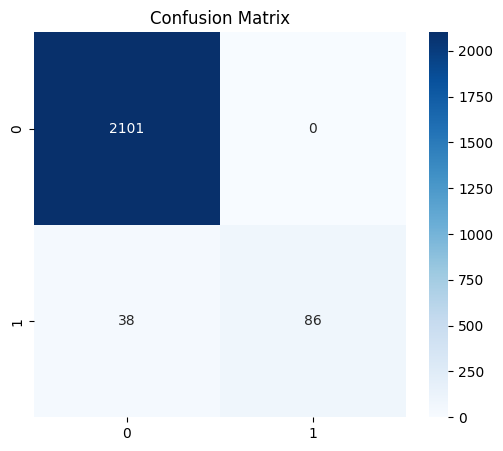

              precision    recall  f1-score   support

           0       0.98      1.00      0.99      2101
           1       1.00      0.69      0.82       124

    accuracy                           0.98      2225
   macro avg       0.99      0.85      0.91      2225
weighted avg       0.98      0.98      0.98      2225



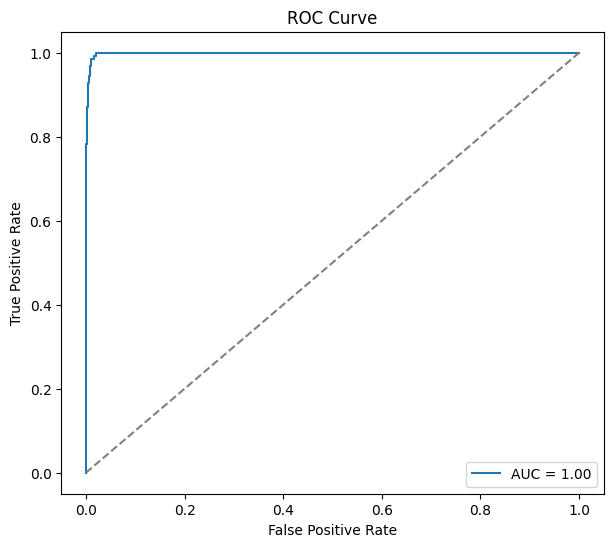

In [24]:
from sklearn.metrics import confusion_matrix, classification_report

X_test_bias = np.c_[np.ones((X_test.shape[0], 1)), X_test]
preds = (sigmoid(np.dot(X_test_bias, weights)) >= 0.5).astype(int)

# Confusion Matrix
cm = confusion_matrix(y_test, preds)
plt.figure(figsize=(6,5))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues')
plt.title("Confusion Matrix")
plt.show()

# Classification report
print(classification_report(y_test, preds))

# ROC Curve
from sklearn.metrics import roc_curve, auc
fpr, tpr, thresholds = roc_curve(y_test, sigmoid(np.dot(X_test_bias, weights)))
roc_auc = auc(fpr, tpr)

plt.figure(figsize=(7,6))
plt.plot(fpr, tpr, label=f'AUC = {roc_auc:.2f}')
plt.plot([0,1],[0,1],'--', color='gray')
plt.title("ROC Curve")
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.legend()
plt.show()


## 9. Model Reflection and Improvement

In this block, we refine and evaluate the Logistic Regression model. We perform hyperparameter tuning to find the best learning rate and number of epochs, analyze feature importance, test different classification thresholds, and assess model performance using confusion matrices, ROC-AUC, and a final classification report.



Training with lr=0.01, epochs=500
Epoch 0, Loss: 0.6931
Epoch 100, Loss: 0.5179
Epoch 200, Loss: 0.4103
Epoch 300, Loss: 0.3401
Epoch 400, Loss: 0.2920
Accuracy: 95.96%

Training with lr=0.01, epochs=1000
Epoch 0, Loss: 0.6931
Epoch 100, Loss: 0.5179
Epoch 200, Loss: 0.4103
Epoch 300, Loss: 0.3401
Epoch 400, Loss: 0.2920
Epoch 500, Loss: 0.2575
Epoch 600, Loss: 0.2318
Epoch 700, Loss: 0.2119
Epoch 800, Loss: 0.1961
Epoch 900, Loss: 0.1833
Accuracy: 96.22%

Training with lr=0.01, epochs=2000
Epoch 0, Loss: 0.6931
Epoch 100, Loss: 0.5179
Epoch 200, Loss: 0.4103
Epoch 300, Loss: 0.3401
Epoch 400, Loss: 0.2920
Epoch 500, Loss: 0.2575
Epoch 600, Loss: 0.2318
Epoch 700, Loss: 0.2119
Epoch 800, Loss: 0.1961
Epoch 900, Loss: 0.1833
Epoch 1000, Loss: 0.1727
Epoch 1100, Loss: 0.1638
Epoch 1200, Loss: 0.1562
Epoch 1300, Loss: 0.1495
Epoch 1400, Loss: 0.1437
Epoch 1500, Loss: 0.1386
Epoch 1600, Loss: 0.1340
Epoch 1700, Loss: 0.1299
Epoch 1800, Loss: 0.1261
Epoch 1900, Loss: 0.1227
Accuracy: 96.49

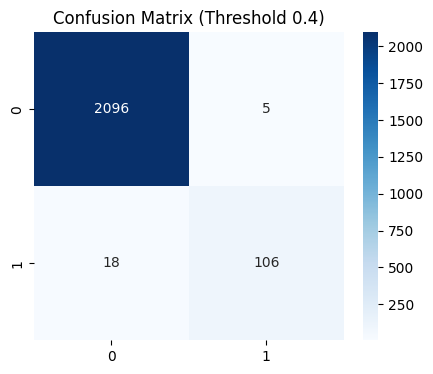

Threshold 0.5: Accuracy = 98.79%


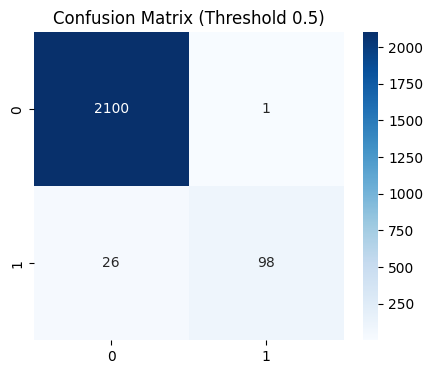

Threshold 0.6: Accuracy = 98.29%


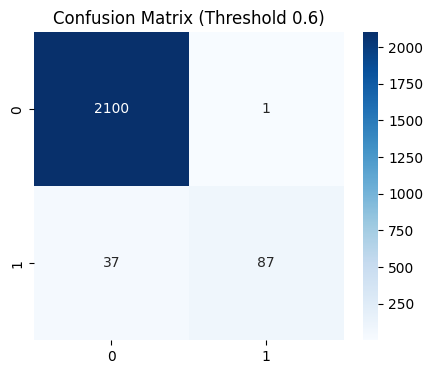

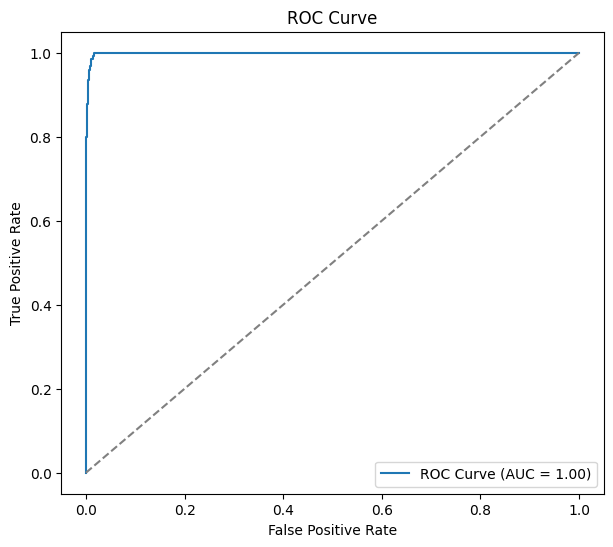

ROC-AUC: 1.00

Classification Report (Threshold 0.5):
              precision    recall  f1-score   support

           0       0.99      1.00      0.99      2101
           1       0.99      0.79      0.88       124

    accuracy                           0.99      2225
   macro avg       0.99      0.89      0.94      2225
weighted avg       0.99      0.99      0.99      2225



In [30]:
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report, roc_curve, auc

# Hyperparameter tuning (learning rate & epochs)
learning_rates = [0.01, 0.05, 0.1]
epochs_list = [500, 1000, 2000]

best_accuracy = 0
best_params = {}

for lr in learning_rates:
    for ep in epochs_list:
        print(f"\nTraining with lr={lr}, epochs={ep}")
        weights_tune = train_logistic_regression(X_train, y_train, lr=lr, epochs=ep)

        X_test_bias = np.c_[np.ones((X_test.shape[0],1)), X_test]
        preds = (sigmoid(np.dot(X_test_bias, weights_tune)) >= 0.5).astype(int)
        acc = accuracy_score(y_test, preds)
        print(f"Accuracy: {acc*100:.2f}%")

        if acc > best_accuracy:
            best_accuracy = acc
            best_params = {'lr': lr, 'epochs': ep, 'weights': weights_tune}

print(f"\nBest Accuracy: {best_accuracy*100:.2f}% with lr={best_params['lr']} and epochs={best_params['epochs']}")
weights = best_params['weights']

# Feature importance
feature_importance = pd.DataFrame({
    'Feature': ['Bias'] + list(X_train.columns),
    'Coefficient': weights.flatten()
})
print("\nFeature Importance (coefficients):")
print(feature_importance.sort_values(by='Coefficient', key=abs, ascending=False))

# Threshold tuning
thresholds = [0.4, 0.5, 0.6]
for t in thresholds:
    preds_t = (sigmoid(np.dot(X_test_bias, weights)) >= t).astype(int)
    acc = accuracy_score(y_test, preds_t)
    print(f"Threshold {t}: Accuracy = {acc*100:.2f}%")

    cm = confusion_matrix(y_test, preds_t)
    plt.figure(figsize=(5,4))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues')
    plt.title(f"Confusion Matrix (Threshold {t})")
    plt.show()

# ROC-AUC evaluation
pred_probs = sigmoid(np.dot(X_test_bias, weights))
fpr, tpr, _ = roc_curve(y_test, pred_probs)
roc_auc = auc(fpr, tpr)

plt.figure(figsize=(7,6))
plt.plot(fpr, tpr, label=f'ROC Curve (AUC = {roc_auc:.2f})')
plt.plot([0,1],[0,1],'--', color='gray')
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("ROC Curve")
plt.legend()
plt.show()

print(f"ROC-AUC: {roc_auc:.2f}")

#  Final evaluation report
final_preds = (pred_probs >= 0.5).astype(int)
print("\nClassification Report (Threshold 0.5):")
print(classification_report(y_test, final_preds))


## 10. Reference List

Kaggle, 2025. Goodreads Books Dataset. [Dataset] Available at: https://www.kaggle.com/datasets/jealousleopard/goodreadsbooks [Accessed 22 October 2025].

Stack Abuse, 2021. Logistic Regression From Scratch in Python. [Online] Available at: https://stackabuse.com/logistic-regression-from-scratch-in-python/ [Accessed 24 October 2025].

Analytics Vidhya, 2020. Logistic Regression: Understanding Gradient Descent. [Online] Available at: https://www.analyticsvidhya.com/blog/2020/10/logistic-regression-understanding-gradient-descent/ [Accessed 21 October 2025].

Scikit-learn, n.d. Metrics and scoring: classification metrics. [Online] Available at: https://scikit-learn.org/stable/modules/model_evaluation.html#classification-metrics [Accessed 27 October 2025].

Scikit-learn, n.d. Preprocessing data. [Online] Available at: https://scikit-learn.org/stable/modules/preprocessing.html [Accessed 23 October 2025].

Seaborn, n.d. Seaborn: statistical data visualization. [Software] Available at: https://seaborn.pydata.org/ [Accessed 28 October 2025].
